# Logistic Regression with Scikit-Learn

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries

Let's import some libraries to get started!

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [30]:
train = pd.read_csv('data/titanic.csv')

In [31]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

### Check for missing data

We can use seaborn to create a simple heatmap to see where we are missing data!

<AxesSubplot:>

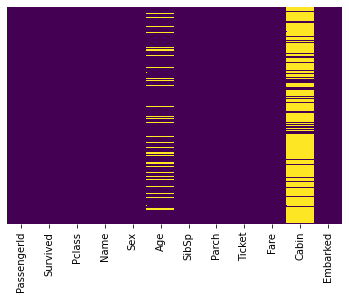

In [32]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Dealing with missing data

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of *imputation*. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0".

(*imputation* is the process of replacing missing data with substituted values)

#### Filling in missing values 

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

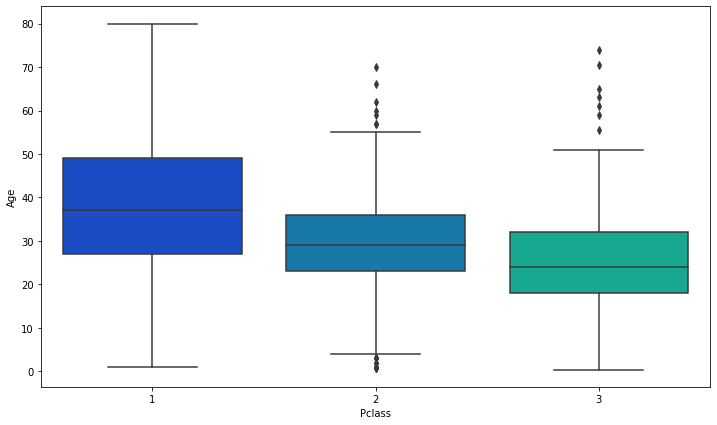

In [33]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [34]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [35]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

<AxesSubplot:>

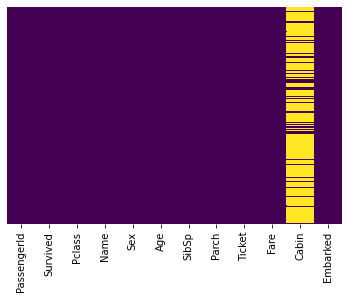

In [36]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column.

In [37]:
train.drop('Cabin',axis=1,inplace=True)

In [38]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Let's see if there are other rows with missing value. 

For this we will rely on `train.isna().any(axis=1)` construct that returns boolean index that has `True` whenever a corresponding row contains at least one missing value:
* `DataFrame.isna` method contains a mask of bool values for each element in DataFrame that indicates whether an element is not an NA value.
* `DataFrame.any` method returns whether any element is True, potentially over an axis.

In [39]:
train[train.isna().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs

For this we will rely on pandas `get_dummies()` function that converts categorical variable into dummy/indicator variables.

In [40]:
sex = pd.get_dummies(train['Sex'],drop_first=True)

,male
0,1
1,0
2,0
3,0
4,1


In [41]:
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [42]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)


In [43]:
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


Now we drop the categorical features and replace them with created 'dummy-coded' data.

In [44]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [45]:
train = pd.concat([train,sex,embark],axis=1)

In [46]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

## Building a Logistic Regression model

Now we are ready to start training our model for predicting whether a passanger survives the Titanic's accident or not.

### Train Test Split

First we start by splitting our data into a training set and test set.

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = \
    train_test_split(train.drop('Survived',axis=1), 
                     train['Survived'], test_size=0.30, 
                     random_state=101)

### Training and Predicting

We are good to start training!

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Let's collect predictions for the texting set in `predictions` series

In [51]:
predictions = logmodel.predict(X_test)

## Evaluation

Let's move on to evaluate our model!

### Classification Report

We can compute precision, recall, f1-score using a single call to `classification_report` function!

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       154
           1       0.78      0.63      0.70       114

    accuracy                           0.77       268
   macro avg       0.77      0.75      0.76       268
weighted avg       0.77      0.77      0.76       268



### ROC-Curve

Now let's draw a plot visualizing ROC-curve (Receiver Operation Characteristics curve)

First let's use `predict_proba` method of our `LogisticRegression` model get probability estimates for class we are predicting: `survived`, which is labled as 1.

In [53]:
y_predict_probabilities = logmodel.predict_proba(X_test)[:,1]

Alsp let's compute False Positive Rate (FPR), True Positive Rate (TPR) and Area Under the Curve using `roc_curve` and `auc` functions from `sklearn.metrics`, where

$$\text{TPR} = \frac {\text{TP}}{\text{P}} = \frac {\text{TP}}{\text{TP+FN}}\text{,}$$
$$\text{FPR} = \frac {\text{FP}}{\text{N}} = \frac {\text{FP}}{\text{TN+FP}}\text{.}$$

In [54]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

Plot the results using matplotlib and display AUC value in the legend.

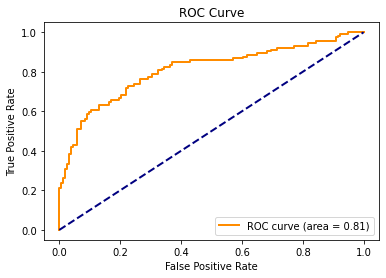

In [55]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?